In [3]:
#!pip install geehydro 

In [4]:
 #!pip install pmdarima

In [5]:
import ee, datetime    # Google Earth Engine
import pandas as pd
import numpy as np
import folium
import geehydro
from datetime import datetime as dt
from IPython.display import Image
import matplotlib.pyplot as plt
import geopandas as gpd
from sentinelsat.sentinel import read_geojson
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Autentication on Google Earth Engine

ee.Authenticate()
ee.Initialize()

Enter verification code: 4/1AX4XfWhgUnM0l5jnwkHQg_v2npMJAoRuOd-ddU20gnp7Hr_-S-ItiytwmFo

Successfully saved authorization token.


In [9]:
# Visualize the Area Of Interest (AOI) in the map: Zambezia

area_map = folium.Map(location=[-13.2512161,34.3015278], zoom_start=6) # zambezia in Mozambique
area_map

In [56]:
# Our chosen Area of Interest is Zambezia province in Mozambique


geojson_f = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              33.4808349609375,
              -13.565901714121072
            ],
            [
              34.21142578125,
              -13.565901714121072
            ],
            [
              34.21142578125,
              -12.168225677390106
            ],
            [
              33.4808349609375,
              -12.168225677390106
            ],
            [
              33.4808349609375,
              -13.565901714121072
            ]
          ]
        ]
      }
    }
  ]
}

In [104]:
# Landsat 8 take images up to 20% cloud coverage
# Take 2 years image data starting at 2019

landsat = ee.ImageCollection("LANDSAT/LC08/C01/T1_RT").filter(ee.Filter.lt('CLOUD_COVER', 20)).\
          filterDate('2019-04-11','2020-11-14')  




# setting the Area of Interest (AOI)
coords = geojson_f['features'][0]['geometry']['coordinates']
area_AOI =  ee.Geometry.Polygon(coords)

# filter area
landsat_AOI = landsat.filterBounds(area_AOI)

In [105]:
print('Total number of images in the collection is :', landsat_AOI.size().getInfo())

Total number of images in the collection is : 91


In [106]:
# Names of each Landsat 8 band

landsat_AOI.first().bandNames().getInfo()

['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'BQA']

For Landsat 8 dataset:

- B4, B3 and B2 are the Red, Green and Blue bands respectively
- B5 is the Near Infrared (NIR) band

In [107]:
# Plot the 'first' image in the collection

# List of images
listOfImages = landsat_AOI.toList(landsat_AOI.size())

# Plot in RGB color composite
palette = ['red', 'green', 'blue']
parameters = {'min': 0,
              'max': 1000,
              'dimensions': 512,
              'bands': ['B4', 'B3', 'B2'],
              'region': area_AOI} 
             
area_map.addLayer(ee.Image(listOfImages.get(1)), parameters)
area_map

##  NDVI Analysis

NDVI of every image pixels in the images will be calculated by the equation:
\begin{equation}
\mbox{NDVI} = \frac{\mbox{NIR} - \mbox{Red}}{\mbox{NIR} + \mbox{Red}}
\end{equation}

Where, NIR is B5 band and Red is B4 band.
Average NDVI will be calculated on every images to get time-series NDVI of the AOI.

### NDVI Calculation

In [108]:
# Function to calculate 'NDVI' and add a additional band to every images in the collection

def addNDVI(image):
    ndvi = image.normalizedDifference(['B5', 'B4']).rename('NDVI')
    return image.addBands(ndvi)

with_ndvi = landsat_AOI.map(addNDVI)

In [109]:
# Function to calculate 'average NDVI' on every images in the collection

def meanNDVI(image):
    image = ee.Image(image)
    meanDict = image.reduceRegion(reducer = ee.Reducer.mean().setOutputs(['NDVI']),
        geometry = area_AOI,
        scale = image.projection().nominalScale().getInfo(),
                                    maxPixels = 100000,
                                    bestEffort = True
                                  )
    
    return meanDict.get('NDVI').getInfo()

In [110]:
# Calculate 'average NDVI' for every images

listOfImages_ndvi = with_ndvi.select('NDVI').toList(with_ndvi.size())

ndvi_collection = []

for i in range(listOfImages_ndvi.length().getInfo()):
    image = ee.Image(listOfImages_ndvi.get(i-1))
    temp_ndvi = meanNDVI(image)
    ndvi_collection.append(temp_ndvi)

In [111]:
# Extract 'dates' from the image collection

dates = np.array(with_ndvi.aggregate_array("system:time_start").getInfo())
day = [datetime.datetime.fromtimestamp(i/1000).strftime('%Y-%m-%d') for i in (dates)]

## Time-series NDVI Dataframe

In [112]:
# Make a dataframe with 'day' and 'NDVI' columns

ndvi_df = pd.DataFrame(ndvi_collection, index = day, columns = ['ndvi'])
ndvi_df.index = pd.to_datetime(ndvi_df.index, format="%Y/%m/%d")
ndvi_df.sort_index(ascending = True, inplace = True)

ndvi_df.head(3)

,ndvi
2019-04-22,0.150819
2019-04-22,0.065588
2019-05-08,0.331206


In [113]:
# Up-sampple the date column

ndvi_df_daily = ndvi_df.resample('D').median()

# Linear interpolate NDVI data

ndvi_df_daily.interpolate(method='polynomial', order = 1, inplace = True)
ndvi_df_daily.head(3)

,ndvi
2019-04-22,0.108204
2019-04-23,0.122141
2019-04-24,0.136079


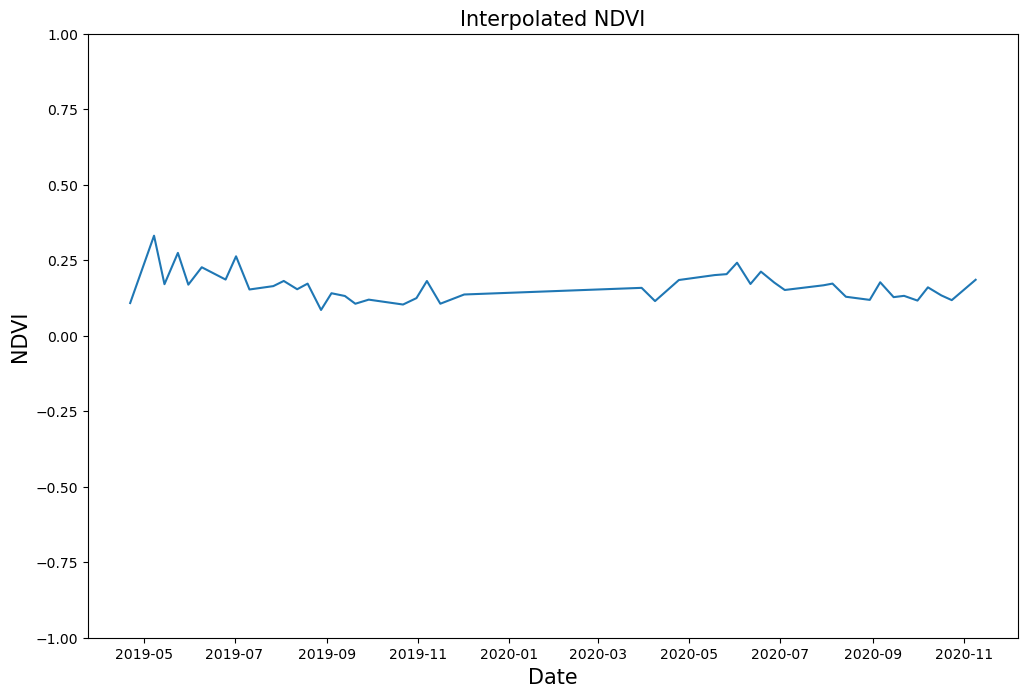

In [114]:
plt.figure(figsize=(12,8), dpi=100)
plt.plot(ndvi_df_daily)
plt.xlabel('Date', fontsize=15)
plt.ylabel('NDVI', fontsize=15)
plt.title("Interpolated NDVI", fontsize=15)
plt.ylim([-1, 1])
plt.show()

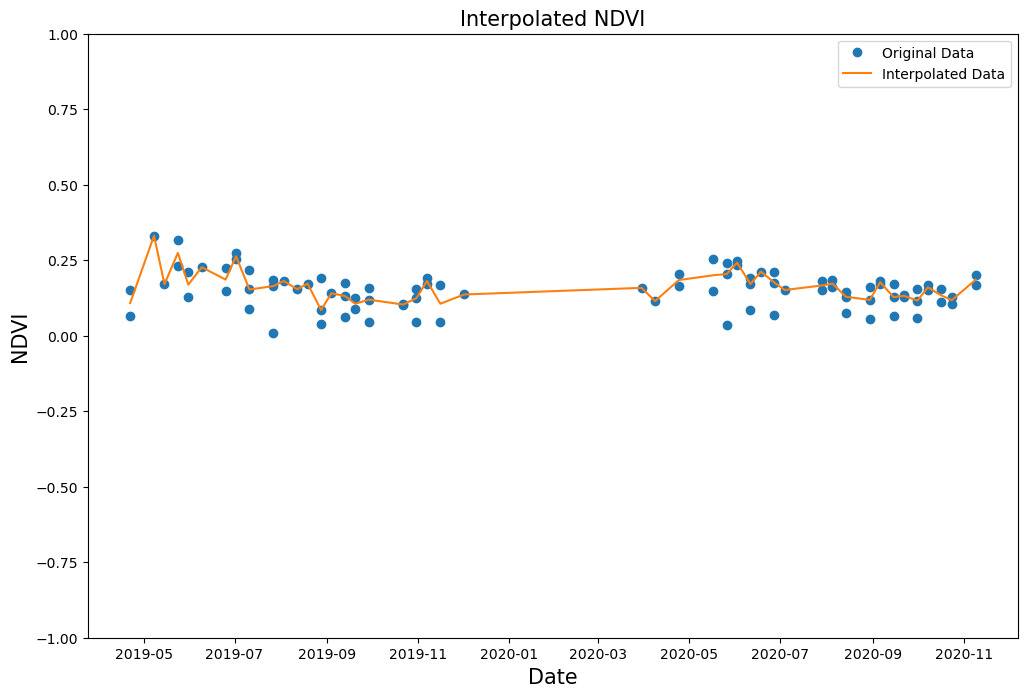

In [115]:
plt.figure(figsize=(12,8), dpi=100)
plt.plot(ndvi_df, 'o')
plt.plot(ndvi_df_daily)
plt.xlabel('Date', fontsize=15)
plt.ylabel('NDVI', fontsize=15)
plt.legend(['Original Data', 'Interpolated Data'])
plt.title("Interpolated NDVI", fontsize=15)
plt.ylim([-1, 1])
plt.show()

In [69]:
def atcorrector(image):
    qa = image.select('QA60')
    bands = ee.List(['B1','B2','B3','B4','B5','B6','B7','B8','B8A','B9','B10','B11','B12'])

    def mapper(band):
        qa = qa.addBands(surface_reflectance(band))
        return band

    bands.map(mapper)
    return qa

ImageCollection.map(atcorrector)

NameError: name 'ImageCollection' is not defined